## Model #2

This model is based on campaign group - clients which already have been taken part in campaign.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2020)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import learning_curve, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv('bank_data_prediction_task.csv', index_col=0)
df['y'] = df['y'].map(lambda x: 1 if x=='yes' else 0) 

In [3]:
df_camp = df[df['test_control_flag']=='campaign group']
df_camp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16476 entries, 1 to 16476
Data columns (total 22 columns):
age                  16476 non-null int64
job                  16476 non-null object
marital              16476 non-null object
education            16476 non-null object
default              16476 non-null object
housing              16476 non-null object
loan                 16476 non-null object
contact              16476 non-null object
month                16476 non-null object
day_of_week          16476 non-null object
duration             16476 non-null float64
campaign             16476 non-null float64
pdays                16476 non-null int64
previous             16476 non-null int64
poutcome             16476 non-null object
emp.var.rate         16476 non-null float64
cons.price.idx       16476 non-null float64
cons.conf.idx        16476 non-null float64
euribor3m            16476 non-null float64
nr.employed          16476 non-null float64
y                    16476 

In [4]:
df_camp.isnull().any().any()

False

In [5]:
df_camp.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,test_control_flag
10733,41,services,married,professional.course,no,no,yes,cellular,nov,thu,217.0,3.0,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,0,campaign group
8074,29,technician,married,professional.course,no,yes,no,cellular,aug,mon,80.0,3.0,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0,campaign group
3680,44,technician,married,professional.course,unknown,no,no,telephone,jun,fri,45.0,1.0,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,0,campaign group
6803,60,retired,married,high.school,unknown,no,no,telephone,jul,fri,133.0,7.0,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0,campaign group
7187,39,technician,married,university.degree,no,yes,no,cellular,jul,wed,141.0,8.0,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0,campaign group


In [6]:
def feat_eng(df):
    
    """Function transforming input data frame by adding new columns and modifing existing. 
    df -- dataframe to transform
    """
    
    basic = ['basic.9y', 'basic.6y', 'basic.4y']
    df['education'] = df['education'].map(lambda x: 'basic' if x in(basic) else x)
    
    cat_feats = ['job', 'marital', 'education','poutcome', 'month', 'contact']
    for cat_feat in cat_feats:
        df['{0}_cat'.format(cat_feat)] = pd.factorize(df[cat_feat])[0]
        
    map_feat = ['default', 'housing', 'loan']
    for f in map_feat:
        df[f] = df[f].apply(lambda x: 1 if x == 'yes' else 0 if  x=='no' else -1)
        
    return df

In [7]:
df_camp_ = feat_eng(df_camp)
df_camp_ = df_camp_.reset_index()

Categorical values have been transformed into numeric. In case of education, values for basic education have been aggregated into one bucket.

In [8]:
df_camp_.sample(5)

,index,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,test_control_flag,job_cat,marital_cat,education_cat,poutcome_cat,month_cat,contact_cat
14607,14608,39,management,married,university.degree,0,1,0,cellular,jun,wed,95.0,1.0,999,0,nonexistent,-2.9,92.963,-40.8,1.260,5076.2,0,campaign group,6,0,3,0,1,1
14227,14228,44,unemployed,married,basic,0,1,0,telephone,may,mon,152.0,4.0,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,0,campaign group,8,0,1,0,0,0
8916,8917,47,admin.,single,university.degree,0,0,0,cellular,aug,thu,310.0,3.0,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0,campaign group,1,1,3,0,3,1
5857,5858,25,blue-collar,single,basic,0,1,0,cellular,jul,tue,159.0,6.0,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0,campaign group,2,1,1,0,2,1
804,805,29,blue-collar,married,professional.course,-1,1,0,telephone,may,mon,79.0,6.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,campaign group,2,0,2,0,0,0


After number of experiments I've choosen only subset of features. 

In [9]:
features = ['age', 'job_cat','marital_cat','education_cat','euribor3m', 'default', 'housing', 'loan', 
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'poutcome_cat','pdays', 'previous', 'contact_cat' ]    
            
X_cv2 = df_camp_.loc[:, features]
y_cv2 = df_camp_.loc[:, 'y']

Cross validation have been prepared to assure proper validation and calculation of success metrics.

In [10]:
def my_cv (m, x, y): 
    
    """Function performs cross validation and calculates mean of success metrics: 
    precision, recall and f1.
    
    m -- model to test
    X -- features to fit model
    y -- target variable
    """
    cv = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)    
    scores_r = []
    scores_p = []
    scores_f = []
    
    for train_idx, test_idx in cv.split(x,y):  
        model = m 
        model.fit(x.loc[train_idx], y[train_idx])
        y_pred = model.predict(x.loc[test_idx])  
        
        score1 = recall_score(y[test_idx], y_pred)
        score2 = precision_score(y[test_idx], y_pred)
        score3 = f1_score(y[test_idx], y_pred)
        
        scores_r.append(score1)
        scores_p.append(score2)
        scores_f.append(score3)     
        
    return round(np.mean(scores_r),3), round(np.mean(scores_p),3), round(np.mean(scores_f),3)

I've verified performance of solution with the use of few models with some regularization.

In [11]:
models = [DummyClassifier(random_state=2020),
          LogisticRegression(random_state=2019),
          RandomForestClassifier(random_state=2020, max_depth=6),
          GradientBoostingClassifier(random_state=2020, max_depth=5),
          xgb.XGBClassifier(random_state=2020, max_depth=5)]

print('     Model      ''\t'' (recall, precision, f1)  ')
for m in models:
    print(type(m).__name__, '\t', my_cv(m, X_cv2, y_cv2))

     Model      	 (recall, precision, f1)  
DummyClassifier 	 (0.1, 0.102, 0.101)
LogisticRegression 	 (0.196, 0.678, 0.303)
RandomForestClassifier 	 (0.184, 0.701, 0.291)
GradientBoostingClassifier 	 (0.248, 0.59, 0.349)
XGBClassifier 	 (0.233, 0.601, 0.336)


Results are better than in model concerning control group. Recall and precision have increased in about 10-15%. Campaign data is helpful in targeting customers.

In this case XGBClassifier have been choosen. F1 score has been used in hyperparameter optimization. However, it is worth considering which success metric is most important. Precision is for sure meaningful because it is not expecting for example to continuosly targeting same clients.  

Some hyperparameters have been found using hyperopt. Results of searching are available [here](#hyp).

#### Final model:

In [15]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.17957894736744226, 
                          random_state=2020, colsample_bytree=0.9217652548701676, subsample=0.8359183414302219)

my_cv(model, X_cv2, y_cv2)

(0.282, 0.585, 0.381)

Validation results after choosing hyperparameters are better than before. There is increase of f1 and recall.

### Learning curves

In [13]:
def plot_learning_curve(estimator, X, y, score='f1', ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.5, 1.0, 6)):
    plt.figure(figsize=(15, 5))
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                                                            train_sizes=train_sizes, scoring=score)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.title(type(estimator).__name__)
    plt.legend(loc="best")
    return plt

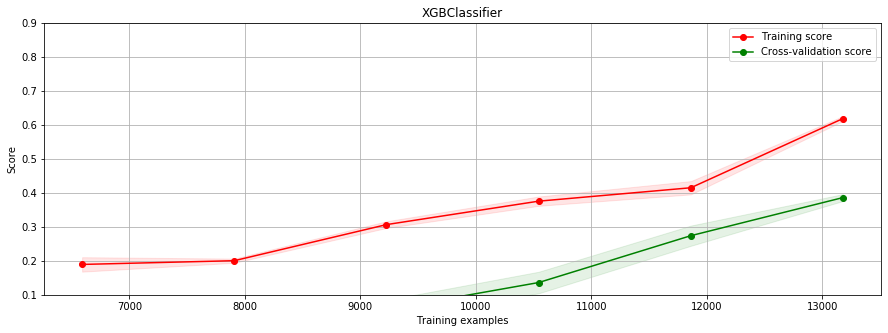

In [16]:
cv = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
model = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.17957894736744226, 
                          random_state=2020, colsample_bytree=0.9217652548701676, subsample=0.8359183414302219)

plot_learning_curve(model, X_cv2, y_cv2, score='f1', ylim=(0.1, 0.9), cv=cv);

Model is overfitted. Let's check if changing hyperparameters will have impact. Model below has smaller depth.

In [17]:
model2 = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.17957894736744226, 
                          random_state=2020, colsample_bytree=0.9217652548701676, subsample=0.8359183414302219)

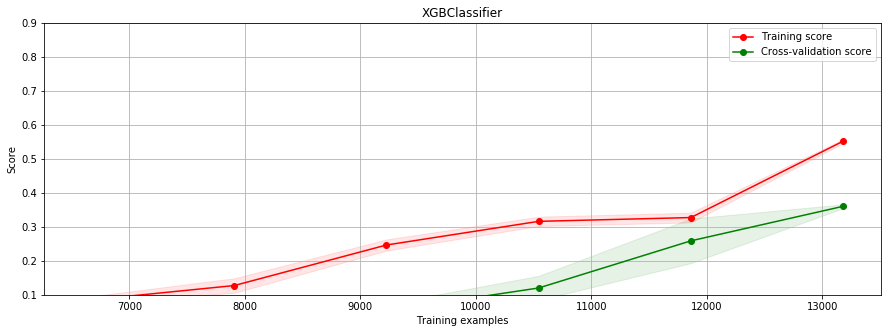

In [18]:
cv = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
plot_learning_curve(model2, X_cv2, y_cv2, score='f1', ylim=(0.1, 0.9), cv=cv);

Indeed, model is now less overfitted, however curves are still not optimal.

In [19]:
my_cv(model2, X_cv2, y_cv2)

(0.265, 0.584, 0.364)

Comparing to previous model F1 score has decreased in 1.5%.

### Precision - recall curves

In [20]:
def plot_precision_vs_recall(precisions, recalls):    
    plt.plot(recalls, precisions, "b-", linewidth=2)    
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)   
    plt.axis([0, 1, 0, 1])

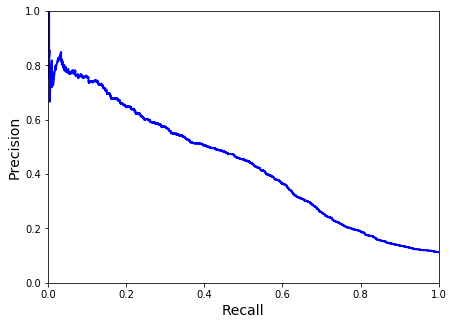

In [21]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.17957894736744226, 
                          random_state=2020, colsample_bytree=0.9217652548701676, subsample=0.8359183414302219)

cv = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True) 
y_predict = cross_val_predict(model, X_cv2, y_cv2, cv=cv, method='predict_proba')
y_pred = y_predict[:,-1]   
precisions, recalls,thresholds = precision_recall_curve(y_cv2, y_pred) 
    
plt.figure(figsize=(7,5))
plot_precision_vs_recall(precisions, recalls)
plt.show();

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):   
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)    
    plt.xlabel("Threshold", fontsize=12)
    plt.legend(loc="down right", fontsize=10)

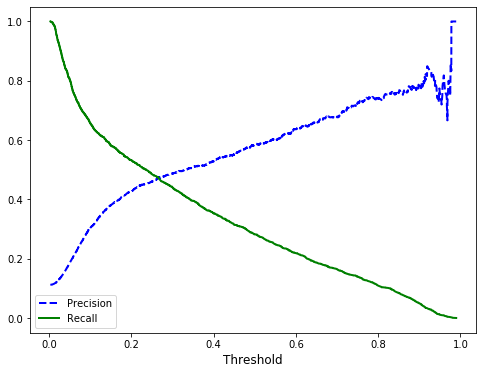

In [23]:
cv = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)    
y_predict = cross_val_predict(model, X_cv2, y_cv2, cv=cv, method='predict_proba')
y_pred = y_predict[:,-1]
precisions, recalls, thresholds = precision_recall_curve(y_cv2, y_pred)  
    
plt.figure(figsize=(8,6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show();

As well as in control group model, performance can change using different threshold in classification algorithms.
Default threshold is 0.5. Changing it below 0.3 results in much higher recall with about 10% decrease in precision.

### ROC curve

In [26]:
def plot_roc_curve(fpr, tpr, label=None):     
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')   
    plt.axis([0, 1, 0, 1])    
    plt.xlabel('False positive rate', fontsize=13)
    plt.ylabel('True positive rate', fontsize=13)

roc auc score: 77.98%


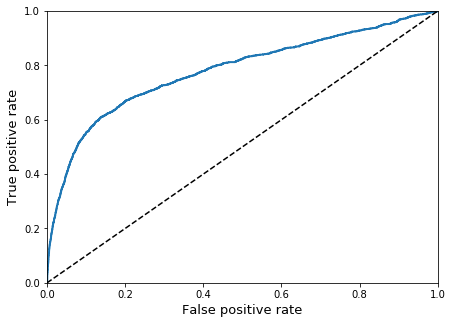

In [25]:
cv = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)    
y_predict = cross_val_predict(model, X_cv2, y_cv2, cv=cv, method='predict_proba')
y_pred = y_predict[:,-1]    
fpr, tpr, thresholds = roc_curve(y_cv2, y_pred) 
    
plt.figure(figsize=(7,5))
print('roc auc score: {}%'.format(round(roc_auc_score(y_cv2, y_pred)*100,2)))    
plot_roc_curve(fpr, tpr)
plt.show()

ROC curve shows that model is not ideal. When level of recall is higher than 60%, rate of false positive increases much faster.

### Threshold modification

In [26]:
def train_and_predict(model, X, y, test_size=0.3, threshold=0.5, matrix=False):   
    
    """Function splits data into train, test set, calculates probabilities based on given threshold 
    and success metrics.
    model -- model to test
    X -- features to fit model
    y -- target variable
    test_size -- proportions how to split data into train and test
    threshold -- probability used to make decision
    matrix -- boolean flag used to print confusion matrix
    """  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020) 

    model.fit(X_train, y_train)    
    y_pred = model.predict_proba(X_test)[:,-1] 
    y_pred_ = np.where(y_pred >= threshold, 1, 0)
        
    prec = np.round(precision_score(y_test, y_pred_),3)
    recc = np.round(recall_score(y_test, y_pred_),3)
    f1 = np.round(f1_score(y_test, y_pred_),3)
    
    if matrix==True:
        print('confusion matrix','\n',confusion_matrix(y_test, y_pred_))   
        
    print('recall, precision, f1')
    return recc, prec, f1

In [27]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.17957894736744226, 
                          random_state=2020, colsample_bytree=0.9217652548701676, subsample=0.8359183414302219)

In [28]:
train_and_predict(model, X=X_cv2, y=y_cv2, test_size=0.3, threshold=0.5, matrix=True)

confusion matrix 
 [[4255  126]
 [ 399  163]]
recall, precision, f1


(0.29, 0.564, 0.383)

In [29]:
train_and_predict(model, X=X_cv2, y=y_cv2, test_size=0.3, threshold=0.3, matrix=True)

confusion matrix 
 [[4124  257]
 [ 308  254]]
recall, precision, f1


(0.452, 0.497, 0.473)

Manipulating of threshold allows to get different values of success metrics. Situation is similar to model concerning control group, however results are about 10-15% better.

### Feature importances

In [30]:
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

Using TensorFlow backend.


In [31]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.17957894736744226, 
                          random_state=2020, colsample_bytree=0.9217652548701676, subsample=0.8359183414302219)

In [32]:
model.fit(X_cv2, y_cv2)
imp = PermutationImportance(model, random_state=2020).fit(X_cv2, y_cv2)

In [33]:
eli5.show_weights(imp, feature_names=features)

Weight,Feature
0.0472 ± 0.0020,euribor3m
0.0188 ± 0.0023,age
0.0085 ± 0.0010,job_cat
0.0080 ± 0.0008,education_cat
0.0078 ± 0.0004,pdays
0.0077 ± 0.0008,contact_cat
0.0071 ± 0.0016,cons.price.idx
0.0065 ± 0.0008,cons.conf.idx
0.0047 ± 0.0008,emp.var.rate
0.0029 ± 0.0006,poutcome_cat


In [34]:
eli5.show_weights(model, feature_names=features)

Weight,Feature
0.1371,euribor3m
0.1196,emp.var.rate
0.1033,pdays
0.1022,poutcome_cat
0.0806,cons.conf.idx
0.0611,contact_cat
0.0549,default
0.0548,cons.price.idx
0.0449,education_cat
0.0439,previous


In [35]:
eli5.explain_weights_xgboost(model.get_booster(), feature_names=features, importance_type='cover')

Weight,Feature
0.0992,contact_cat
0.0977,euribor3m
0.0908,cons.conf.idx
0.0877,cons.price.idx
0.0841,default
0.0809,emp.var.rate
0.0807,pdays
0.0685,poutcome_cat
0.0641,previous
0.0530,age


Features from campaign have impact, however economic and demographic indicators are still on top.

<a id='hyp'></a>
### Hyperparameters optimalization

In [28]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial

In [29]:
def my_cv_h2 (m, x, y):    
    
    cv = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)    
    scores_f = []
    
    for train_idx, test_idx in cv.split(x,y):  
        model = m 
        model.fit(x.loc[train_idx], y[train_idx])
        y_pred = model.predict(x.loc[test_idx])      
        score3 = f1_score(y[test_idx], y_pred)
        scores_f.append(score3) 
        
    return  round(np.mean(scores_f),3)

In [30]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'n_estimators': space['n_estimators']
    }
    
    model = xgb.XGBClassifier(**xgb_params, random_state=2020)

    score = my_cv_h2 (model, X_cv2, y_cv2)
    print(xgb_params)
    print("SCORE: {0}".format(score))    
    return{'loss':-score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.choice ('x_max_depth', np.arange(2, 7, dtype=int)),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'n_estimators':hp.choice ('x_n_estimators', [80,90,100]),
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=50,
            trials=trials)

print("The best params: ", best_params)

{'max_depth': 4, 'colsample_bytree': 0.9557503725917902, 'learning_rate': 0.12122655622460218, 'subsample': 0.9566289722865002, 'n_estimators': 100}
SCORE: 0.338                                                                   
{'max_depth': 4, 'colsample_bytree': 0.9706751018355909, 'learning_rate': 0.11975323553662051, 'subsample': 0.9839568531793935, 'n_estimators': 100}
SCORE: 0.345                                                                   
{'max_depth': 4, 'colsample_bytree': 0.9964055869825678, 'learning_rate': 0.05101996767260199, 'subsample': 0.9953348872700364, 'n_estimators': 80}
SCORE: 0.308                                                                   
{'max_depth': 6, 'colsample_bytree': 0.8092421511633765, 'learning_rate': 0.18775358115735774, 'subsample': 0.7259139190019885, 'n_estimators': 90}
SCORE: 0.376                                                                   
{'max_depth': 6, 'colsample_bytree': 0.8005698643308977, 'learning_rate': 0.1993568775

In [31]:
trials.best_trial

{'state': 2,
 'tid': 19,
 'spec': None,
 'result': {'loss': -0.386, 'status': 'ok'},
 'misc': {'tid': 19,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_colsample_bytree': [19],
   'x_learning_rate': [19],
   'x_max_depth': [19],
   'x_n_estimators': [19],
   'x_subsample': [19]},
  'vals': {'x_colsample_bytree': [0.8490378145122782],
   'x_learning_rate': [0.19743479289808583],
   'x_max_depth': [4],
   'x_n_estimators': [1],
   'x_subsample': [0.751778107822571]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 3, 11, 21, 22, 0, 971000),
 'refresh_time': datetime.datetime(2020, 3, 11, 21, 22, 7, 211000)}